# Imports

In [70]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.options import Options
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import time
import requests
import os

# Webscrape

In [71]:
url = "http://www.prideinthejersey.com/jerseysindex.html"

countyList = []

try:
    response = requests.get(url)
    response.raise_for_status()  # Raises an HTTPError if the status is 4xx, 5xx

    soup = BeautifulSoup(response.text, 'html.parser')
    
    for div in divs:
        a_tag = div.find('a')
        if a_tag and 'href' in a_tag.attrs:
            countyList.append(a_tag['href'])
except requests.exceptions.HTTPError as err:
    print(f"HTTP error occurred: {err}")
except Exception as e:
    print(f"An error occurred: {e}")

countyList = [county.replace(".html", "") for county in countyList]
countyList.remove("NewYork") # This webpage is not available
countyList.append("Tipperary")

print(countyList)

['antrim', 'armagh', 'carlow', 'cavan', 'cork', 'derry', 'donegal', 'down', 'dublin', 'fermanagh', 'galway', 'Kerry', 'Kilkenny', 'laois', 'Leitrim', 'limerick', 'london', 'longford', 'louth', 'Kildare', 'Mayo', 'Meath', 'Monaghan', 'Offaly', 'Roscommon', 'Sligo', 'tyrone', 'Waterford', 'Westmeath', 'Clare', 'Wexford', 'Wicklow', 'Tipperary']


In [91]:
options = Options()
options.add_argument("--headless")

driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

In [92]:
for county in countyList:
    # Ensure the 'jerseys' directory exists
    base_dir = 'jerseys'
    county_dir = os.path.join(base_dir, county)
    if not os.path.exists(county_dir):
        os.makedirs(county_dir)
    
    driver.get(f"http://www.prideinthejersey.com/{county}.html")

    try:
        element = driver.find_element(By.CLASS_NAME, "photoGalleryImageStageContainer")
        element.click()
        print(f"Downloading {county} Images")
    except Exception as e:
        print(f"Error clicking the element: {e}")
    
    for num in range(25):
        try:
            next_link = driver.find_element(By.ID, "nextLink")
            next_link.click()
            time.sleep(1.5)  # Corrected comment to match the delay
            
            # Get the image number and total count from the span element
            number_display_element = driver.find_element(By.ID, "numberDisplay")
            image_info = number_display_element.text.split()  # Split by whitespace
            if len(image_info)>0:
                current_image_number = int(image_info[1])  # Extract X
                total_image_count = int(image_info[3])  # Extract Y
            else:
                current_image_number=0
                total_image_count=1
            
            image_element = driver.find_element(By.ID, "lightboxImage")
            image_src = image_element.get_attribute('src')
            if image_src:
                response = requests.get(image_src)
                if response.status_code == 200:
                    image_path = os.path.join(county_dir, f'{county}_{num}.jpg')
                    with open(image_path, 'wb') as file:
                        file.write(response.content)
                else:
                    print("All images downloaded")
                    break
            # Check if all images have been downloaded
            if current_image_number == total_image_count:
                print("All images downloaded")
                break
    
        except Exception as e:
            print(f"Error clicking nextLink: {e}")
            break  # Exit the loop if there's an error (e.g., element not found)

driver.quit()

All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded
All images downloaded


# Setup Data

The data will be split into training and test data

In [93]:
# Define the path to your main directory
base_dir = 'jerseys'

# Initialize the ImageDataGenerator for the training set
# Note: You can add data augmentation parameters here if needed
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # Splitting data; 80% for training, 20% for validation
)

# Load images from directories and automatically assign labels based on folder names
train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),  # Resize images
    batch_size=32,
    class_mode='categorical',  # or 'categorical' if you have more than two classes
    subset='training'  # Set as training data
)

validation_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',  # Match with the class_mode of the training generator
    subset='validation'  # Set as validation data
)

Found 512 images belonging to 33 classes.
Found 119 images belonging to 33 classes.


## Training Images
Let's have a look at some of the training images

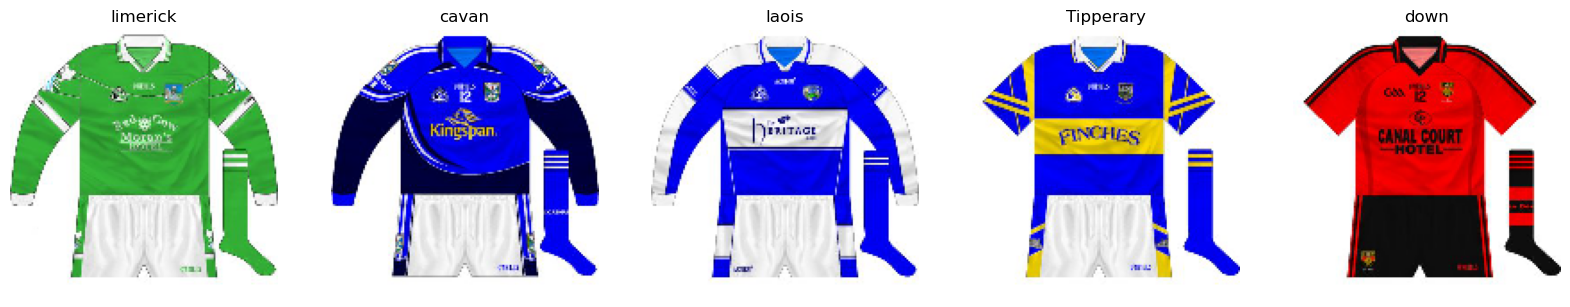

In [94]:
# Assuming 'train_generator' is already defined and loaded with binary class_mode
class_indices = train_generator.class_indices  # This is a dictionary mapping
class_labels = list(class_indices.keys())  # Get class labels as list

# Get a batch of images and labels
images, labels = next(train_generator)

# Adjusted to work with categorical class_mode
def show_images(images, labels):
    _, axs = plt.subplots(1, len(images), figsize=(20, 5))
    if len(images) == 1:
        axs = [axs]
    for img, ax, label_array in zip(images, axs, labels):
        label = class_labels[np.argmax(label_array)]  # Corrected line
        ax.imshow(img)
        ax.set_title(label)
        ax.axis('off')
    plt.show()

show_images(images[:5], labels[:5])

In [96]:
# Adjust the last layer for categorical classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    # Update the number of neurons to match the number of classes, use softmax
    Dense(33, activation='softmax')  
])

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model with the categorical dataset
model.fit(train_generator, validation_data=validation_generator, epochs=4)

Epoch 1/4
16/16 [==============================] - 3s 154ms/step - loss: 4.2566 - accuracy: 0.2031 - val_loss: 1.8091 - val_accuracy: 0.6303
Epoch 2/4
16/16 [==============================] - 2s 145ms/step - loss: 1.0089 - accuracy: 0.7891 - val_loss: 0.5555 - val_accuracy: 0.8739
Epoch 3/4
16/16 [==============================] - 2s 143ms/step - loss: 0.2937 - accuracy: 0.9375 - val_loss: 0.1880 - val_accuracy: 0.9832
Epoch 4/4
16/16 [==============================] - 2s 145ms/step - loss: 0.1045 - accuracy: 0.9668 - val_loss: 0.1170 - val_accuracy: 0.9748


4/4 [==============================] - 0s 39ms/step


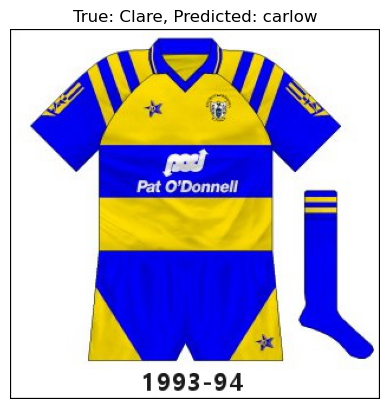

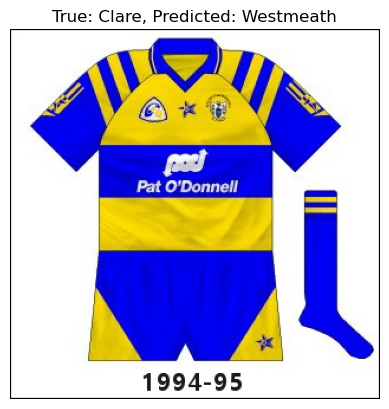

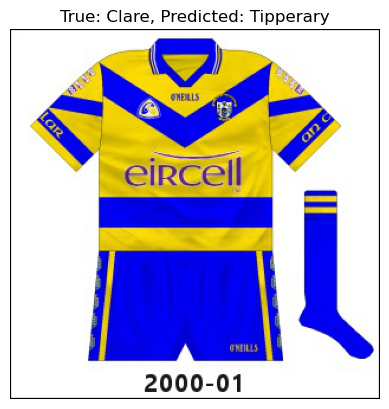

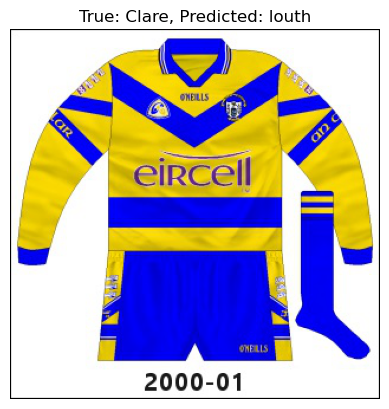

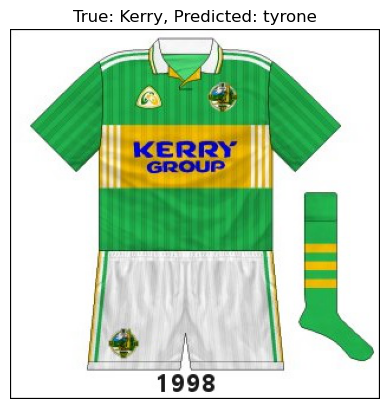

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Predict the classes of the validation set
predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get the true classes
true_classes = validation_generator.classes

# Get the class labels
class_labels = list(validation_generator.class_indices.keys())

# Find the indices of misclassified images
misclassified_indices = np.where(predicted_classes != true_classes)[0]

# Display a few misclassified images
num_images_to_display = min(5, len(misclassified_indices))
for i in range(num_images_to_display):
    index = misclassified_indices[i]
    img_path = validation_generator.filepaths[index]  # Get the image file path
    true_label = class_labels[true_classes[index]]
    predicted_label = class_labels[predicted_classes[index]]

    # Open and display the image
    try:
        img = Image.open(img_path)
        plt.imshow(img)
        plt.title(f'True: {true_label}, Predicted: {predicted_label}')
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error loading image '{img_path}': {e}")


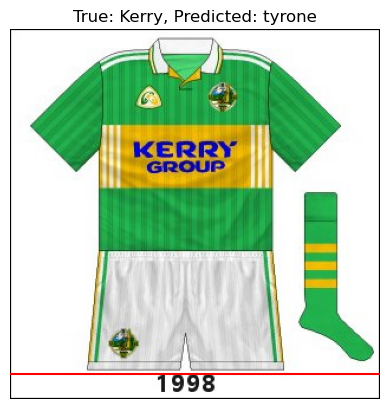

In [102]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Open the image
img = Image.open(img_path)

# Create a Matplotlib figure and axis
fig, ax = plt.subplots()

# Display the image
ax.imshow(img)

# Get the height of the image
height = img.size[1]

# Calculate the y-coordinate for the horizontal line
line_y = height * 0.93  # 10% up from the bottom

# Draw the horizontal line
ax.axhline(y=line_y, color='red')

# Set title and turn off axis
plt.title(f'True: {true_label}, Predicted: {predicted_label}')
plt.axis('off')

# Show the plot
plt.show()


In [60]:
# Predict Matches

# https://en.wikipedia.org/wiki/2022_National_Football_League_(Ireland)

In [ ]:
linkchecker http://www.example.com/